Practice neural network model training workflow

In [217]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [218]:
torch.__version__

'2.7.1'

In [238]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


### workflow
1. data - prepare and load
2. build model
3. fitting the model to data (training)
4. making predictions and evaluating a model (inference)
5. saving and loading a model

improving through experimentation 


Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation.

### 1. Data (Preparing and loading)

In [219]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)

y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Three datasets
1. Training set -- model learn patterns from
2. Validation set -- tune model patterns
3. Test set -- see if the model is ready for the wild

Generalization: the ability for a machine leaning model to perform well on data it hasn't seen before

In [220]:
train_split = int(0.8 * len(X))
train_split

40

In [221]:
# in our simple case, just split the data; otherwise sckit learn has sklearn.model_selection.train_test_split 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test)

(40, 10)

In [222]:
def plot_predications(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predications=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
    plt.scatter(test_data, test_labels, c='g', s=4, label="Testing Data")

    if predications is not None:
        plt.scatter(test_data, predications, c='r', s=4, label="Predictions")

    plt.legend(prop={"size": 4});    


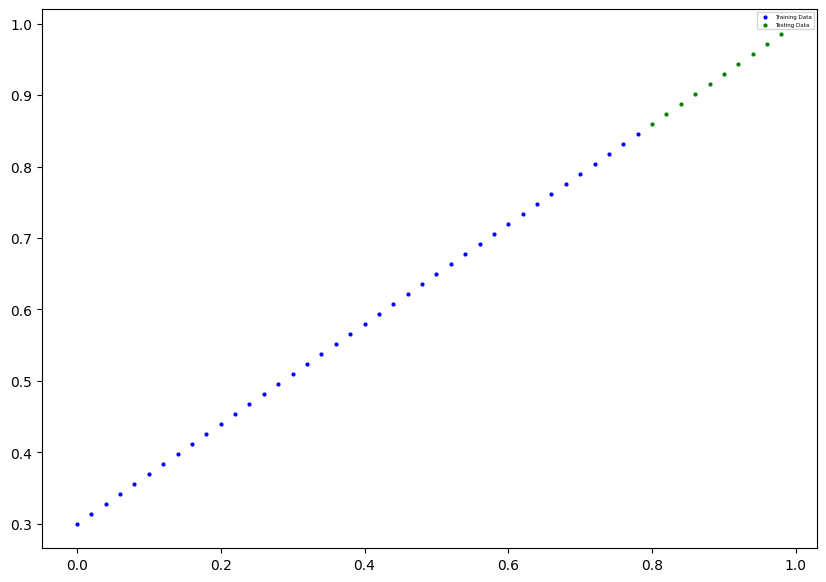

In [223]:
plot_predications();

### 2. build model

# create a liner regression model class


In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # layers, parameters, hard-coded values, or functions

        # start with a random number
        # could use nn.Linear() instead (it is also called linear transform, probing layer, fully connected layer, dense layer etc.)
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=float))

    # requires_grad to be true, pytorch will track the gradients of the parameter, for use by torch.autograd and gradient descents
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias


In [225]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()

model_0

LinearRegressionModel()

In [226]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], dtype=torch.float64, requires_grad=True)]

In [227]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])),
             ('bias', tensor([0.1288], dtype=torch.float64))])

In [228]:
# make a predication for now even not trained yet
with torch.inference_mode():
    y_preds = model_0(X_test)

# can also do this but inference_mode is prefered as it does a more that just no_grad
# with torch.no_grad():
#     y_preds = model_0(X_test)
    
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], dtype=torch.float64)

In [229]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

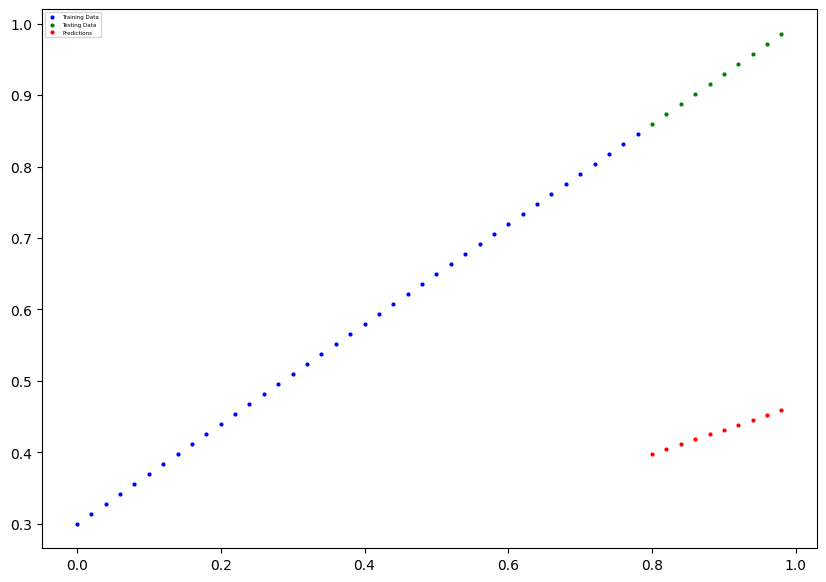

In [230]:
plot_predications(predications=y_preds)

In [231]:
1e-3

0.001

In [232]:
# train model
# but first, we need a loss function and an optimizer to train the model

loss_fn = nn.L1Loss()
# parameters and learning rates
optimizer = torch.optim.SGD(model_0.parameters(), lr=1e-2)


### setup training loop
1. loop through the data
2. forward pass also called forward propagation
3. calculate the loss
4. optimizer zero grad
5. backpropagation: loss backward - move backwards through the network to caculate the gradients of each parameter, with respect to the loss
6. optimizer step - use the optimizer to adjust our model's parameters to try and improve loss (calculate the gradient descent)

In [233]:
# an epoch is one loop through the data
epochs = 200

epoch_count = []
loss_count = []
test_loss_count = []
# loop through the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train()

    # 1. forward pass
    y_pred = model_0(X_train)

    # 2. calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. perform backpropagation on the loss with respect to the parameter of the model
    loss.backward()

    # 5. step the optimizer - perform the gradent descent -- by default, how the optimizer changes will accumulate through the loop, so we have to zero the grad
    optimizer.step()

    #
    model_0.eval() # turn off different settings in the model not needed for evaluation/testing: dropout/batch norm layers
    with torch.inference_mode():
        # forward pass
        test_pred = model_0(X_test)
        
        # calculate the loss
        test_loss = loss_fn(test_pred, y_test)

        #
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            loss_count.append(loss)
            test_loss_count.append(test_loss)
            print(f"Epoch: {epoch} | Loss: {loss} | Test Loss {test_loss}")



Epoch: 0 | Loss: 0.3128813540030115 | Test Loss 0.48106518251847774
Epoch: 10 | Loss: 0.1976713878151804 | Test Loss 0.34635525805902023
Epoch: 20 | Loss: 0.08908726197128397 | Test Loss 0.21729659826707373
Epoch: 30 | Loss: 0.053148534844695394 | Test Loss 0.14464020545434486
Epoch: 40 | Loss: 0.04543796626385301 | Test Loss 0.11360953803014288
Epoch: 50 | Loss: 0.041678633706817264 | Test Loss 0.09919951553296583
Epoch: 60 | Loss: 0.038189322985123564 | Test Loss 0.08886642677735816
Epoch: 70 | Loss: 0.034760873781118265 | Test Loss 0.08059397036981117
Epoch: 80 | Loss: 0.03132381429875812 | Test Loss 0.07232151992272866
Epoch: 90 | Loss: 0.027887363194275382 | Test Loss 0.06473596281957157
Epoch: 100 | Loss: 0.024458912872682963 | Test Loss 0.05646351833295364
Epoch: 110 | Loss: 0.02102017967401617 | Test Loss 0.0481910589451743
Epoch: 120 | Loss: 0.017585401633914276 | Test Loss 0.040605486940856125
Epoch: 130 | Loss: 0.014155356578143156 | Test Loss 0.03233303351354137
Epoch: 140 

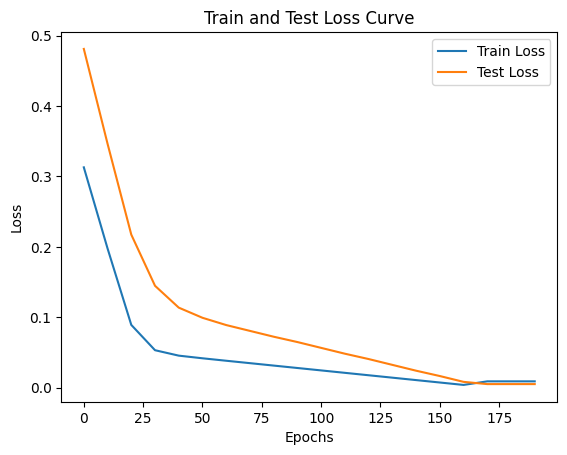

In [234]:
plt.plot(epoch_count, torch.tensor(loss_count).numpy(), label="Train Loss")
plt.plot(epoch_count, torch.tensor(test_loss_count).numpy(), label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss Curve")
plt.legend();

In [235]:
with torch.inference_mode():        
    y_preds_new = model_0(X_test)

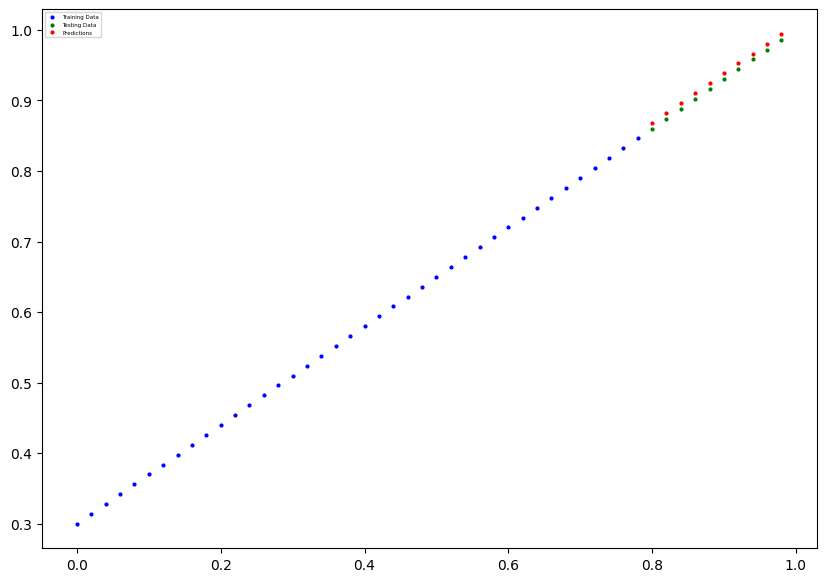

In [236]:
plot_predications(predications=y_preds_new)

### Save and load a model in PyTorch
1. `torch.save()` in python's pickle format
2. `torch.load()` load a saved model
3. `torch.nn.Module.load_state_dict()` load a model's saved dictionary

In [237]:
from pathlib import Path